In [249]:
import torch
from torch import tensor, matmul, FloatTensor
import numpy as np
import matplotlib.pyplot as plt

$\text{Input Domain}: L_\infty$

$$
\psi : \left( \begin{array}{c}x \\ y \\ \end{array} \right)=
\left( \begin{array}{c}x_0 \\ y_0 \\ \end{array} \right)
+\epsilon_1\left( \begin{array}{c} \eta \\ 0 \\ \end{array} \right)
+\epsilon_2 \left( \begin{array}{c}0 \\ \eta \\ \end{array} \right)
$$

$\forall\,i,\,-1\leq\epsilon_i\leq1$

Affine transform

$$
\left(
\begin{array}{cc}
 w_{1,1} & w_{1,2} \\
 w_{2,1} & w_{2,2} \\
\end{array}
\right).\left(
\begin{array}{ccc}
 x_0 & \eta  & 0 \\
 y_0 & 0 & \eta  \\
\end{array}
\right)+\left(
\begin{array}{c}
 b_1 & 0 & 0 \\
 b_2 & 0 & 0\\
\end{array}
\right)
$$

In [3]:
def box(x):
    radius = torch.sum(torch.abs(x[1:]))
    return x[0] - radius, x[0] + radius

$$
ReLU^{\#}(x)=
\lambda  x+ \frac{1}{2} \left(\epsilon _{\text{new}}+1\right)\begin{cases}
 -l \lambda  & \lambda >\frac{u}{u-l} \\
 u (1-\lambda ) & \text{Otherwise} \\
\end{cases}
$$

In [260]:
def relu_layer_transformer(layer, lambdas):
    boxes =  [box(n) for n in layer]
    _, epsilon_id = layer.shape
    for i, (l, u), lmb in zip(range(len(layer)), boxes, lambdas):
        if u <= 0:
            for val in layer[i]:
                val = 0
        elif l < 0:
            layer = torch.nn.ConstantPad2d((0, 1),0)(layer)  
            layer[i] *= lmb
            
            if lmb >= u/(u-1):
                layer[i][epsilon_id] = -l * lmb / 2
            else:
                layer[i][epsilon_id] = u * (1 - lmb)

            layer[i][0] += layer[i][epsilon_id]
            epsilon_id += 1
            
    return layer

def add_bias(layer, bias):
    #A probably worse approach is to pad right and matrix add
    #return layer + torch.nn.ConstantPad2d((0, layer.shape[1] - 1),0)(b)
    for n, b in zip(layer, bias):
        n[0] += b[0]
    return layer

tensor([[ 7.6076, -2.1672,  2.1672,  1.6847,  3.7556],
        [ 7.6464, -2.1768,  2.1768,  2.4696,  0.0000]], grad_fn=<CopySlices>)


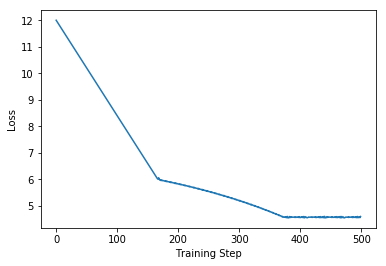

In [274]:
lmb1 = torch.tensor([1.,5], requires_grad=True)
lmb2 = torch.tensor([0.,1.], requires_grad=True)
loss_history = []
for _ in range(500):
    layer = tensor([[1.,-1,1],[-2.,1,-1]])

    layer = relu_layer_transformer(layer, lmb1)

    w = torch.tensor([[-1, 1],[2, -1]], dtype=torch.float)
    b = torch.tensor([[1],[2]], dtype=torch.float)
    layer = add_bias(matmul(w , layer), b)
    layer = relu_layer_transformer(layer, lmb2)

    loss = torch.sum(torch.abs(layer[1] - layer[0]))
    loss_history.append(loss)
    loss.backward(retain_graph=True)
    
    if lmb1.grad is not None:
        lmb1 = (lmb1 - .001 * lmb1.grad).clone().detach().requires_grad_(True)
    if lmb2.grad is not None:
        lmb2 = (lmb2 - .001 * lmb2.grad).clone().detach().requires_grad_(True)

print(layer)
plt.plot(loss_history);
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.show()